In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetic-retinopathy-detection/train.zip.003
/kaggle/input/diabetic-retinopathy-detection/test.zip.004
/kaggle/input/diabetic-retinopathy-detection/test.zip.005
/kaggle/input/diabetic-retinopathy-detection/train.zip.002
/kaggle/input/diabetic-retinopathy-detection/test.zip.006
/kaggle/input/diabetic-retinopathy-detection/test.zip.003
/kaggle/input/diabetic-retinopathy-detection/train.zip.005
/kaggle/input/diabetic-retinopathy-detection/train.zip.001
/kaggle/input/diabetic-retinopathy-detection/sampleSubmission.csv.zip
/kaggle/input/diabetic-retinopathy-detection/test.zip.007
/kaggle/input/diabetic-retinopathy-detection/trainLabels.csv.zip
/kaggle/input/diabetic-retinopathy-detection/test.zip.001
/kaggle/input/diabetic-retinopathy-detection/sample.zip
/kaggle/input/diabetic-retinopathy-detection/train.zip.004
/kaggle/input/diabetic-retinopathy-detection/test.zip.002


In [2]:
# Import necessary libraries
import os
import zipfile
import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, concatenate, Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import ResNet50, EfficientNetB0, DenseNet121
from keras.layers import Attention
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from keras import backend as K
from sklearn.metrics import accuracy_score, classification_report
#from sklearn.calibration import temperature_scaling
import shap

In [5]:
!apt install p7zip-full -y
!7z x ../input/diabetic-retinopathy-detection/train.zip.001 "-i!train/11*.jpeg" -y
!mkdir data
!mv train data/train_11

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-7build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../input/diabetic-retinopathy-detectio                                                1 file, 8388608000 bytes (8000 MiB)

Extracting archive: ../input/diabetic-retinopathy-detection/train.zip.001
  0% 1 Ope          --
Path = ../input/diabetic-retinopathy-detection/train.zip.001
Type = Split
Physical Size = 8388608000
Volumes = 5
Total Physical Size = 34988445506
----
Path = train.zip
Size = 34988445506
--
Path = train.zip
Type = zip
Physical Size = 34988445506
64-bit = +

      1% 10 - train/11010_left.jpe                           

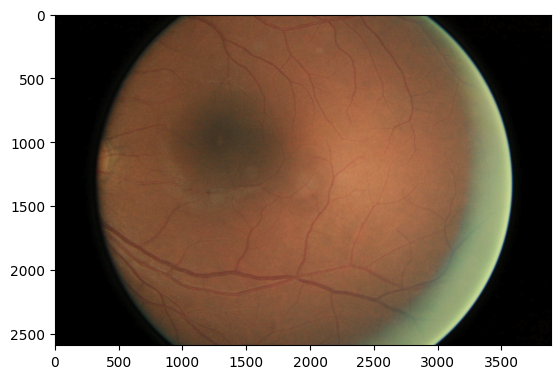

In [6]:
train_sample = Image.open("./data/train_11/1116_right.jpeg")
plt.imshow(train_sample)

In [7]:
!7z x ../input/diabetic-retinopathy-detection/test.zip.001 "-i!test/11*.jpeg" -y
!mv test data/test_11


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ../input/diabetic-retinopathy-detectio                                                1 file, 8388608000 bytes (8000 MiB)

Extracting archive: ../input/diabetic-retinopathy-detection/test.zip.001
  0% 1 Ope          --
Path = ../input/diabetic-retinopathy-detection/test.zip.001
Type = Split
Physical Size = 8388608000
Volumes = 7
Total Physical Size = 53289598430
----
Path = test.zip
Size = 53289598430
--
Path = test.zip
Type = zip
Physical Size = 53289598430
64-bit = +

      0% 9 - test/11006_right.jp                              1% 17 - test/11014_right.jpe                                1% 26 - test/11019_left.jp                              2% 34 - test/11022_left.jp                              3% 45 - test/11029_right.jpe                          

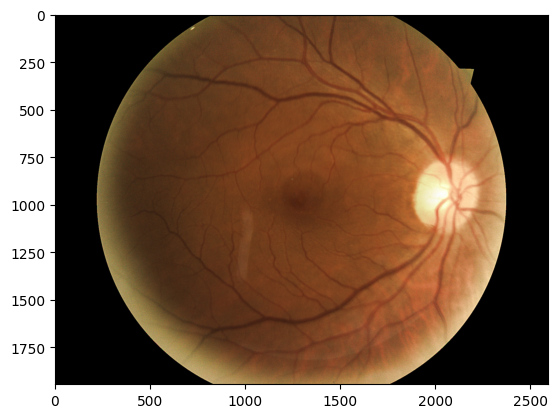

In [10]:
test_sample = Image.open("./data/test_11/11984_right.jpeg")
plt.imshow(test_sample)

In [14]:
!unzip ../input/diabetic-retinopathy-detection/trainLabels.csv.zip
base_image_dir = os.path.join('.', 'data/train_11')
df = pd.read_csv(os.path.join('./trainLabels.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True)#shuffle dataframe
df['level'] = df['level'].astype(str)
df.head(10)

Archive:  ../input/diabetic-retinopathy-detection/trainLabels.csv.zip
  inflating: trainLabels.csv         


,level,path
0,2,./data/train_11/11156_right.jpeg
1,0,./data/train_11/11550_right.jpeg
2,0,./data/train_11/11691_left.jpeg
3,0,./data/train_11/11305_left.jpeg
4,2,./data/train_11/11863_left.jpeg
5,0,./data/train_11/11464_right.jpeg
6,0,./data/train_11/11534_right.jpeg
7,0,./data/train_11/11720_right.jpeg
8,2,./data/train_11/11455_right.jpeg
9,0,./data/train_11/11904_right.jpeg


In [15]:
import os
import cv2
import numpy as np
import imgaug.augmenters as iaa

def apply_adaptive_histogram_equalization(image_path, output_folder):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_img = clahe.apply(img)

    # Save the result
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, equalized_img)

def apply_advanced_augmentations(image_path, output_folder):
    # Read the image
    img = cv2.imread(image_path)

    # Define augmentations
    seq = iaa.Sequential([
        iaa.ElasticTransformation(alpha=50, sigma=5),
        iaa.AdditiveGaussianNoise(scale=0.05 * 255)
    ])

    # Apply augmentations
    augmented_img = seq.augment_image(img)

    # Save the result
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, augmented_img)

def apply_gaussian_blurring(image_path, output_folder):
    # Read the image
    img = cv2.imread(image_path)

    # Apply Gaussian Blurring
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

    # Save the result
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, blurred_img)
    
def process_images_in_folder(input_folder, output_folder, processing_function):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Process each image in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpeg"):
            input_path = os.path.join(input_folder, filename)
            processing_function(input_path, output_folder)

if __name__ == "__main__":
    # Set paths
    input_folder = "data/train_11" 
    output_folder_equalization = "data/train_11_eq"
    output_folder_augmentation = "data/train_11_aug"
    output_folder_blurring = "data/train_11_blur"

    # Apply Adaptive Histogram Equalization
    process_images_in_folder(input_folder, output_folder_equalization, apply_adaptive_histogram_equalization)

    # Apply Image Augmentation
    process_images_in_folder(input_folder, output_folder_augmentation, apply_advanced_augmentations)

    # Apply Gaussian Blurring
    process_images_in_folder(input_folder, output_folder_blurring, apply_gaussian_blurring)

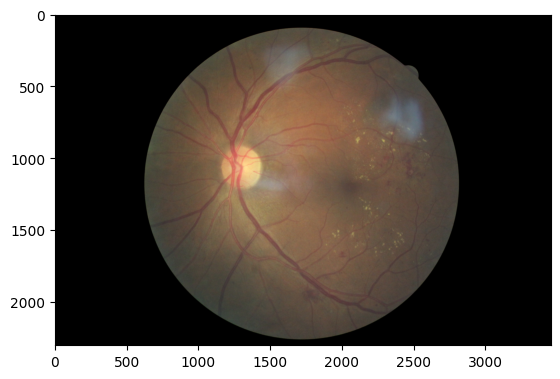

In [16]:
original_img = Image.open("./data/train_11/11871_left.jpeg")
plt.imshow(original_img)

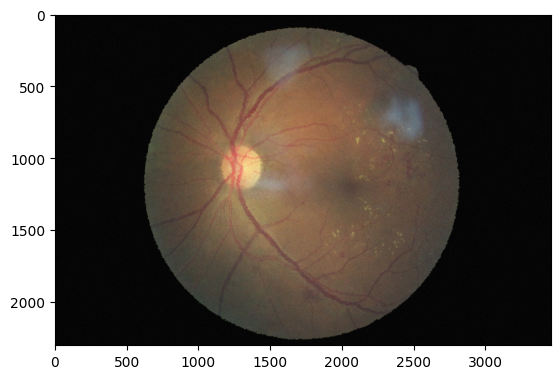

In [17]:
augmented_img = Image.open("./data/train_11_aug/11871_left.jpeg")
plt.imshow(augmented_img)

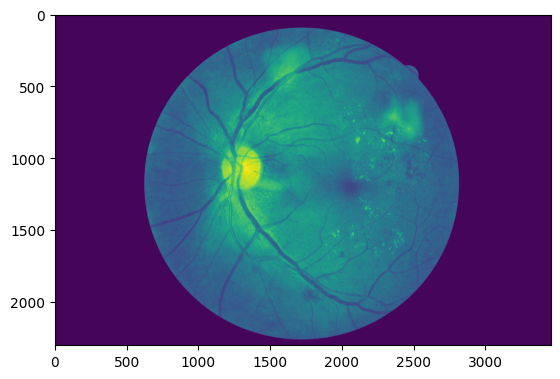

In [18]:
equalized_img = Image.open("./data/train_11_eq/11871_left.jpeg")
plt.imshow(equalized_img)

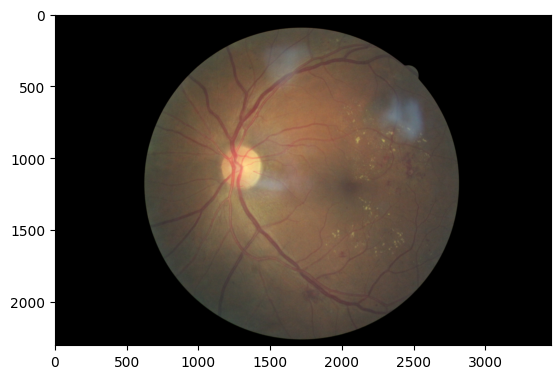

In [19]:
blur_img = Image.open("./data/train_11_blur/11871_left.jpeg")
plt.imshow(blur_img)

In [20]:
# Function to load and preprocess images
def load_and_preprocess_images(image_paths, target_size=(224, 224), augment=False):
    img_list = []
    for path in image_paths:
        img = image.load_img(path, target_size=target_size)
        img = image.img_to_array(img)
        img /= 255.0  # Normalize pixel values to be between 0 and 1
        img_list.append(img)

    return np.array(img_list)

In [21]:
# Function to create an ensemble model
def create_ensemble_model(input_shape, num_classes):
    # Define base models
    base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of base models
    for layer in base_model_resnet.layers:
        layer.trainable = False
    for layer in base_model_efficientnet.layers:
        layer.trainable = False
    for layer in base_model_densenet.layers:
        layer.trainable = False

    # Create input layer
    input_tensor = Input(shape=input_shape)

    # Get intermediate layer outputs
    resnet_features = base_model_resnet(input_tensor)
    efficientnet_features = base_model_efficientnet(input_tensor)
    densenet_features = base_model_densenet(input_tensor)

    # Concatenate features
    concatenated_features = concatenate([resnet_features, efficientnet_features, densenet_features], axis=-1)

    # Global average pooling layer
    x = GlobalAveragePooling2D()(concatenated_features)

    # Dropout layer
    x = Dropout(0.5)(x)

    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=input_tensor, outputs=output)

    # Compile model
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [22]:
# Function to train the model
def train_model(model, train_data, train_labels, val_data, val_labels, epochs=30, batch_size=32):
    # Define callbacks
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        train_data,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_data, val_labels),
        callbacks=[checkpoint, early_stopping]
    )

    return history

In [23]:
# Function to evaluate the model
def evaluate_model(model, test_data, test_labels):
    predictions = model.predict(test_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(test_labels, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    print("Test Accuracy:", accuracy)

    report = classification_report(y_true, y_pred)
    print("Classification Report:\n", report)

In [24]:
# Function for model calibration using temperature scaling
def calibrate_model(model, val_data, val_labels):
    val_predictions = model.predict(val_data)
    temperature = temperature_scaling(val_labels, val_predictions)
    calibrated_predictions = val_predictions / temperature

    return calibrated_predictions

In [25]:
# Function to visualize feature importance using SHAP
def visualize_feature_importance(model, data, background_data):
    # Create a SHAP explainer
    explainer = shap.Explainer(model, background_data)

    # Calculate SHAP values
    shap_values = explainer.shap_values(data)

    # Plot feature importance
    shap.summary_plot(shap_values, data)

In [27]:
# Set paths
data_folder = "data"

# Extract images from train zip files
train_images_folder = "train_11"

# Extract images from test zip files
test_images_folder = "test_11"

In [28]:
# Load labels
labels_df = df
image_paths = [os.path.join(train_images_folder, f"{idx}_left.jpeg") for idx in labels_df['path']]
image_paths += [os.path.join(train_images_folder, f"{idx}_right.jpeg") for idx in labels_df['path']]
labels = labels_df['level'].values

In [29]:
image_path = labels_df['path'].values
label = labels_df['level'].values

In [30]:
# Split the data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(image_path, label, test_size=0.2, random_state=42, stratify=labels)

In [31]:
# Load and preprocess training and validation data
train_images = load_and_preprocess_images(train_data, augment=True)
val_images = load_and_preprocess_images(val_data)

In [32]:
# Convert labels to one-hot encoding
le = LabelEncoder()
train_labels_encoded = to_categorical(le.fit_transform(train_labels))
val_labels_encoded = to_categorical(le.transform(val_labels))

In [33]:
# Data augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
)
datagen.fit(train_images)

In [34]:
# Train-test split for calibration
calib_train_data, calib_val_data, calib_train_labels, calib_val_labels = train_test_split(train_images, train_labels_encoded, test_size=0.1, random_state=42, stratify=train_labels_encoded)

In [35]:
# Create an ensemble model
input_shape = (224, 224, 3)  # Adjust based on the target model input size
num_classes = 5  # 0 to 4 severity levels
ensemble_model = create_ensemble_model(input_shape, num_classes)

29084464/29084464 [==============================] - 1s 0us/step


In [37]:
history = train_model(ensemble_model, train_images, train_labels_encoded, val_images, val_labels_encoded, epochs=30, batch_size=32)


Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 1.3205 - accuracy: 0.5796
Epoch 1: val_loss improved from inf to 1.04584, saving model to best_model.h5


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


22/22 [==============================] - 222s 9s/step - loss: 1.3205 - accuracy: 0.5796 - val_loss: 1.0458 - val_accuracy: 0.6971
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 1.1022 - accuracy: 0.6456
Epoch 2: val_loss improved from 1.04584 to 1.03113, saving model to best_model.h5
22/22 [==============================] - 171s 8s/step - loss: 1.1022 - accuracy: 0.6456 - val_loss: 1.0311 - val_accuracy: 0.6971
Epoch 3/30
22/22 [==============================] - ETA: 0s - loss: 1.0572 - accuracy: 0.6772
Epoch 3: val_loss improved from 1.03113 to 0.94440, saving model to best_model.h5
22/22 [==============================] - 167s 8s/step - loss: 1.0572 - accuracy: 0.6772 - val_loss: 0.9444 - val_accuracy: 0.6971
Epoch 4/30
22/22 [==============================] - ETA: 0s - loss: 0.9766 - accuracy: 0.6700
Epoch 4: val_loss improved from 0.94440 to 0.91055, saving model to best_model.h5
22/22 [==============================] - 167s 8s/step - loss: 0.9766 - accuracy: 0

In [39]:
ensemble_model.save("best_model.h5")

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [52]:
from tensorflow.keras.models import load_model

# Load the saved H5 model
ensemble_model = load_model('best_model.h5')

#ensemble_model = joblib.load("best_model.h5")

In [53]:
# Evaluate the model
evaluate_model(ensemble_model, val_images, val_labels_encoded)


6/6 [==============================] - 38s 5s/step
Test Accuracy: 0.6971428571428572
Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82       122
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         3

    accuracy                           0.70       175
   macro avg       0.14      0.20      0.16       175
weighted avg       0.49      0.70      0.57       175



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [65]:
from sklearn.calibration import CalibratedClassifierCV

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_encoded, test_size=0.2, random_state=42, stratify=train_labels_encoded)

ensemble_model.fit(X_train, y_train)

# Calibrate the model using temperature scaling
calibrated_model = CalibratedClassifierCV(ensemble_model, method='sigmoid', cv='prefit')
calibrated_model.fit(X_train, y_train)

18/18 [==============================] - 99s 5s/step - loss: 0.8340 - accuracy: 0.7020


In [ ]:
calibrated_proba = calibrated_model.predict_proba(X_val)

# Evaluate the performance
calibrated_log_loss = log_loss(y_val, calibrated_proba)

In [ ]:
# Calibrate the model
calibrated_predictions = calibrate_model(ensemble_model, calib_val_data, calib_val_labels)

In [ ]:
# Visualize feature importance using SHAP
background_data = calib_train_data[np.random.choice(calib_train_data.shape[0], 100, replace=False)]
visualize_feature_importance(ensemble_model, calib_val_data, background_data)